In [1]:
import pandas as pd
import numpy as np
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")
import glob
import random
import sys
import networkx as nx
import matplotlib.pyplot as plt
# import folium
import osmnx as ox
import pandana as pdna
import libpysal as lps
import seaborn as sns
import mapclassify as mc
# import esda
from difflib import SequenceMatcher
from pathlib import Path
import statsmodels.api as sm
from scipy import stats
from statsmodels.graphics.api import abline_plot

import six
import uuid
import pickle
from sqlalchemy import create_engine

engine = create_engine('postgresql://postgres@localhost:5432/david')

from matplotlib import colors
from matplotlib.collections import LineCollection
from shapely.geometry import Point, Polygon
from utils import show_values
pd.set_option('display.max_columns', 500)

sys.path.append('/Users/david/Dropbox/PhD/Scripts/Spatial analyses')
# import pyspace

## Import FDGC's data

In [89]:
#Set working directory
mydir = Path(os.getcwd())
data_folder = mydir / '../Data' #Set data folder
result_folder = mydir / '../Results' #Set data folder

In [3]:
file = data_folder /'Raw data'/ "extractionGE_v3.csv" #Data source file containing the screening data
df = pd.read_csv(file,sep = ";",low_memory = False) #Load data

In [4]:
len(df.numeroDossier.unique())

136529

## Import administrative gdfs

In [5]:
lake = gpd.read_file('/Users/david/Dropbox/PhD/GitHub/COVID19/Data/Mapping/lake.geojson')
cantons = gpd.read_file(
    '/Users/david/Dropbox/PhD/Data/Databases/SITG/SHAPEFILE_LV95_LN02/swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET.shp')
communes = gpd.read_file(
    '/Users/david/Dropbox/PhD/Data/Databases/SITG/SHAPEFILE_LV95_LN02/swissBOUNDARIES3D_1_3_TLM_HOHEITSGEBIET.shp')
communes = communes[communes.KANTONSNUM == 25]
cantons = cantons.to_crs(2056)
communes = communes.to_crs(2056)

## Feature engineering

In [6]:
df['dateInvitation'] = pd.to_datetime(df['dateInvitation'])
df['dateMammographie'] = pd.to_datetime(df['dateMammographie'])

df['year_invit'] = df.dateInvitation.dt.year
df['year_mammo'] = df.dateMammographie.dt.year

In [7]:
df = df.assign(mammo = 1* (df.dateMammographie.isnull()==False))

## Pre-geocoding address cleaning

In [8]:
#Set all column names to lowercase
df.columns = map(str.lower, df.columns)

#eliminate noisy information from addresses
df.loc[df.adresse1.str.contains('C/O')==True, 'adresse1'] = '' 
df.loc[df.adresse1.str.contains('CASE POSTALE')==True, 'adresse1'] = ''
df.loc[df.adresse2.str.contains('CASE POSTALE')==True, 'adresse2'] = ''
df.loc[df.adresse2.isnull()==True, 'adresse2'] = ''

#Create new column containing country information
df['country'] = 'Suisse'
df.loc[df.npa.str.contains('F-|FR-')==True, 'country'] = 'France'
df.loc[df.localité.str.contains('FRANCE')==True, 'country'] = 'France'

# df['city'] = df['city'].astype(str)
# df.loc[df.city == 'Athenaz (Avusy)','city'] = 'Avusy'
# df.loc[df.city == 'Chambésy','city'] ='Pregny-Chambésy'
# df.loc[df.city.str.contains('Lancy'),'city'] = 'Lancy'
# df.loc[df.city == 'Collex','city'] = 'Collex-Bossy'
# df.loc[df.city == 'La Croix-de-Rozon','city'] = 'Bardonnex'
# df.loc[df.city == 'Perly','city'] = 'Perly-Certoux'
# df.loc[df.city.str.contains('Meyrin'),'city'] = 'Meyrin'
# df.loc[df.city.str.contains('Grand-Lancy'),'city'] = 'Grand-Lancy'
# df.loc[df.city.str.contains('Petit-Lancy'),'city'] = 'Petit-Lancy'
#Repare npa field
df['npa'] = df['npa'].str.replace('F-','').str.replace('FR -','').str.replace('F -','').str.replace('F','').str.replace('-','').str.strip().replace('',np.nan)
df['npa'] = df.npa.fillna(-1).astype(float).astype(int)
df['npa'] = df['npa'].astype(str).replace('-1',np.nan)

#Create new column : street
df['street'] = df['adresse1'] +' '+ df['adresse2']
df['street'] = df['street'].replace(',','', regex = True)

df = df.rename(columns = {'npa':'zipcode','localité':'city'})
df['canton'] = 'ge'
df.to_feather(data_folder/'first_cleanup_giracs.feather')

_regbl_data_folder = Path("/Users/david/Dropbox/PhD/GitHub/Swiss-Geocoder/").resolve()
regbl_address = pd.read_feather(_regbl_data_folder / 'Data' /'Clean_data'/ 'regbl_address_2022.feather')
regbl_street = pd.read_feather(_regbl_data_folder / 'Data' /'Clean_data'/ 'regbl_street_2022.feather')

In [9]:
df.shape

(596980, 26)

## Post-geocoding 

Geocoding using in-house procedure based on string-matching against a CH Federal database on all existing addresses in the country.

In [10]:
### Geocoded dataset
df_geocoded = pd.read_excel(data_folder/'Processed data'/'giracs_geocoded_80.xlsx')
df_geocoded = df_geocoded.drop(['Unnamed: 0'], axis = 1)

In [11]:
df_geocoded.loc[df_geocoded.city.str.contains('Meyrin', na=False),'city'] = 'Meyrin'
df_geocoded.loc[df_geocoded.city.str.contains('Lancy', na=False),'city'] = 'Lancy'
df_geocoded.loc[df_geocoded.city.str.contains('Genève', na=False),'city'] = 'Genève'

In [12]:
#Transform variable to binary
df_geocoded.loc[df_geocoded.medecin == 'oui','medecin_code'] =1
df_geocoded.loc[df_geocoded.medecin == 'non','medecin_code'] =0
df_geocoded.loc[df_geocoded.medecin == 'je ne sais pas','medecin_code'] = np.nan

In [13]:
#Transform variable to binary
df_geocoded.loc[df_geocoded.autremedecin == 'oui','autremedecin_code'] =1
df_geocoded.loc[df_geocoded.autremedecin == 'non','autremedecin_code'] =0
df_geocoded.loc[df_geocoded.autremedecin == 'je ne sais pas','autremedecin_code'] = np.nan

In [14]:
#Transform variable to binary
df_geocoded.loc[df_geocoded.mammoanterieure == 'oui','mammoanterieure_code'] =1
df_geocoded.loc[df_geocoded.mammoanterieure == 'non','mammoanterieure_code'] =0
df_geocoded.loc[df_geocoded.mammoanterieure == 'je ne sais pas','mammoanterieure_code'] = np.nan

In [15]:
#Transform variable to binary
df_geocoded.loc[df_geocoded.atf == 'oui','atf_code'] =1
df_geocoded.loc[df_geocoded.atf == 'non','atf_code'] =0
df_geocoded.loc[df_geocoded.atf == 'je ne sais pas','atf_code'] = np.nan

In [16]:
#Transform variable to binary
rappel = 1* (df_geocoded.daterappel.isnull()==False)
df_geocoded = df_geocoded.assign(rappel = rappel)

In [17]:
#Transform variable to binary
df_geocoded = df_geocoded.assign(mammo = 1* (df_geocoded.datemammographie.isnull()==False))

In [18]:
#Create variables from date columns
df_geocoded['dateinvitation'] = pd.to_datetime(df_geocoded['dateinvitation'])
df_geocoded['daterappel'] = pd.to_datetime(df_geocoded['daterappel'])
df_geocoded['datemammographie'] = pd.to_datetime(df_geocoded['datemammographie'])

In [19]:
#Create variables from date columns
df_geocoded['t_invit_rappel'] = df_geocoded['daterappel'] - df_geocoded['dateinvitation']
df_geocoded['t_invit_rappel']= df_geocoded['t_invit_rappel']/np.timedelta64(1,'D')

df_geocoded['t_invit_mammo'] = df_geocoded['datemammographie'] - df_geocoded['dateinvitation']
df_geocoded['t_invit_mammo']= df_geocoded['t_invit_mammo']/np.timedelta64(1,'D')

In [20]:
#Create variables from date columns
df_geocoded['year_invit'] = df_geocoded.dateinvitation.dt.year
df_geocoded['month_invit'] = df_geocoded.dateinvitation.dt.month
df_geocoded['day_invit'] = df_geocoded.dateinvitation.dt.day
df_geocoded['weekday_invit'] = df_geocoded.dateinvitation.dt.day_name()

df_geocoded['year_rappel'] = df_geocoded.daterappel.dt.year
df_geocoded['month_rappel'] = df_geocoded.daterappel.dt.month
df_geocoded['day_rappel'] = df_geocoded.daterappel.dt.day
df_geocoded['weekday_rappel'] = df_geocoded.daterappel.dt.day_name()

df_geocoded['year_mammo'] = df_geocoded.datemammographie.dt.year
df_geocoded['month_mammo'] = df_geocoded.datemammographie.dt.month
df_geocoded['day_mammo'] = df_geocoded.datemammographie.dt.day
df_geocoded['weekday_mammo'] = df_geocoded.datemammographie.dt.day_name()

In [21]:
#Return a sequence that corresponds to the actual numeroinvitation ...without the weird things we find in the original column
df_geocoded['dt_invit'] = pd.to_datetime([f'{y}-{m}-{d}' for y, m, d in zip(df_geocoded.year_invit, df_geocoded.month_invit, df_geocoded.day_invit)])
df_geocoded = df_geocoded.sort_values(['numerodossier','dt_invit'])
df_geocoded['numeroinvitation_seq'] = df_geocoded.groupby('numerodossier').cumcount()+1

In [22]:
n_invit = df_geocoded.groupby('numerodossier').numeroinvitation_seq.nunique()
df_geocoded = df_geocoded.join(n_invit, on='numerodossier', rsuffix='_n')

#### Participation changes between any two invitation (to the same woman)

In [23]:
df_geocoded['mammo_last_invite'] = df_geocoded[['numerodossier','mammo']].groupby('numerodossier').diff()['mammo']

In [24]:
participation_chg = pd.DataFrame(df_geocoded[['numerodossier','mammo_last_invite']].groupby(['mammo_last_invite']).numerodossier.count()).reset_index()
participation_chg.columns = ['Participation change','n']
participation_chg['%'] = participation_chg['n'].mul(100)/participation_chg['n'].sum(axis = 0)
participation_chg['%'] = participation_chg['%'].round(2)

In [25]:
participation_change = df_geocoded[['numerodossier','mammo_last_invite']].dropna().groupby(['numerodossier']).mammo_last_invite.nunique().reset_index()
participation_change.columns = ['numerodossier','participation_change']
participation_change['participation_change'] = participation_change['participation_change']-1
df_geocoded = df_geocoded.merge(participation_change, on='numerodossier',how = 'left')

#### Time intervals between any two invitation (to the same woman)

In [26]:
%%time
df_geocoded['diff_years'] = df_geocoded[['numerodossier','dt_invit']].groupby('numerodossier').diff()['dt_invit']/np.timedelta64(1,'Y')

CPU times: user 19.2 ms, sys: 8.54 ms, total: 27.8 ms
Wall time: 27.9 ms


In [27]:
df_geocoded.shape

(596980, 58)

### Discard 2021 invitations

In [28]:
df_geocoded = df_geocoded[df_geocoded.year_invit != 2021]
print('Number of invitations :', df_geocoded.shape[0])
print('Number of women :', df_geocoded.numerodossier.nunique())

Number of invitations : 590117
Number of women : 135772


### Discard duplicates

In [29]:
clean_dupli =df_geocoded[(df_geocoded.duplicated(subset=['numerodossier','numeroinvitation'],keep=False))].sort_values(['numerodossier','month_invit','day_invit','mammo','groupeage']).drop_duplicates(subset = ['numerodossier','numeroinvitation'],keep = 'first')

df_geocoded['_dummy'] = df_geocoded['numerodossier'].astype(str) + df_geocoded['numeroinvitation'].astype(str)
clean_dupli['_dummy'] = clean_dupli['numerodossier'].astype(str) + clean_dupli['numeroinvitation'].astype(str)

df_geocoded = df_geocoded[(df_geocoded._dummy.isin(clean_dupli._dummy))==False]

df_geocoded = pd.concat([df_geocoded,clean_dupli])

print('Number of invitations :', df_geocoded.shape[0])
print('Number of women :', df_geocoded.numerodossier.nunique())

Number of invitations : 589879
Number of women : 135772


In [30]:
579033/589879

0.9816131782958878

### Discard out of age range invitations

In 1999, population-based breast cancer screening was introduced in the canton of Geneva, an area with approximately 500 000 inhabitants. All individuals aged **50-74** are invited from a central screening centre to a biennial screening cycle. The programme was gradually expanded by successively inviting new birth cohorts, and was fully rolled-out in 2013. The different age cohorts included varied in size due to natural vartions in the population.

# A VERIFIER !!!



In [31]:
df_geocoded.groupeage = df_geocoded.groupeage.astype('category')
df_geocoded['groupeage_cat'] = df_geocoded.groupeage.cat.codes

In [32]:
#Get age categories that are out of the age range guidelines for breast cancer screening
age_cats = df_geocoded.groupby('groupeage').size()
age_cats1000 = age_cats[age_cats > 1000]
age_cats =  pd.DataFrame(age_cats).reset_index()
age_cats.columns = ["Age group","Invitation count (n)"]

In [33]:
df_geocoded = df_geocoded[(df_geocoded.groupeage.isin(['50-54','55-59','60-64','65-69','70-74']))]

In [34]:
print('Number of invitations :', df_geocoded.shape[0])
print('Number of women :', df_geocoded.numerodossier.nunique())

Number of invitations : 585522
Number of women : 135664


In [35]:
589879 - 585522

4357

In [36]:
# Exclude 70-74 invited before 2013 since it wasn't rolled out yet
df_geocoded = df_geocoded[~((df_geocoded['year_invit'] < 2013) & (df_geocoded['groupeage'] == '70-74'))]

In [37]:
print('Number of invitations :', df_geocoded.shape[0])
print('Number of women :', df_geocoded.numerodossier.nunique())

Number of invitations : 581325
Number of women : 135203


In [38]:
585522- 581325

4197

In [39]:
#Create geodataframe
gdf_geocoded = gpd.GeoDataFrame(df_geocoded,crs = 2056,geometry = gpd.points_from_xy(df_geocoded['E'],df_geocoded['N']))
# Create geodataframe of unique addresses
gdf_geom_uniq = gdf_geocoded.drop_duplicates(subset = ['address_id','full_address'])
# Create geodataframe of all rows having a valid geocoding
gdf_geocoded_ok = gdf_geocoded[gdf_geocoded.comment.str.contains('Ok')]

In [40]:
#Print the number of different geometries after small alteration to addresses
gdf_geocoded.groupby('comment').size()

comment
Low quality                     1575
Low quality - Street level       199
No match                          62
Not in CH                        305
Ok                            578791
Ok - Street level                393
dtype: int64

In [41]:
gdf_geocoded[~gdf_geocoded.comment.str.contains('Ok')].shape[0]

2141

In [42]:
gdf_geocoded[gdf_geocoded.comment.str.contains('Ok')].shape[0]

579184

In [43]:
print('Number of invitations :', gdf_geocoded_ok.shape[0])
print('Number of women :', gdf_geocoded_ok.numerodossier.nunique())

Number of invitations : 579184
Number of women : 134845


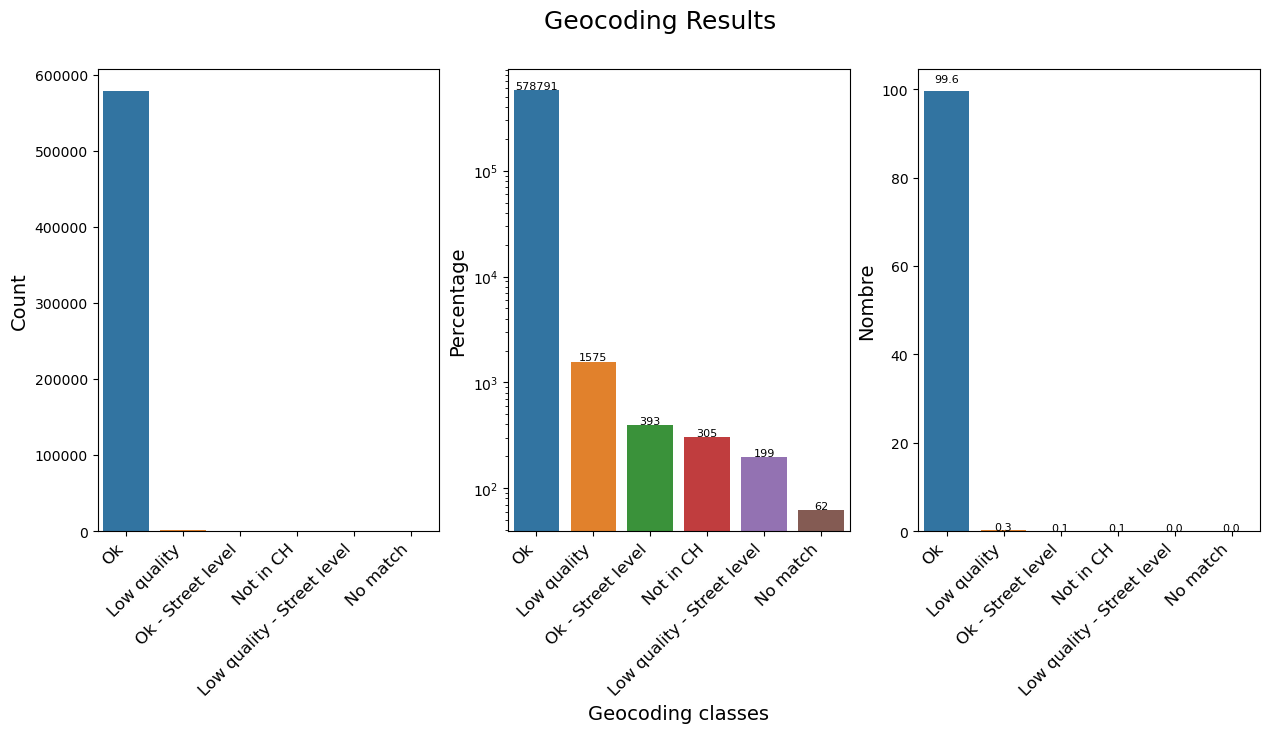

In [44]:
# sns.set_theme(style="white")
# sns.set_context("paper")

fig, axes = plt.subplots(1,3, figsize=(15, 6), sharey=False, sharex=True)
fig.suptitle('Geocoding Results', size = 18)
geocoding_res = pd.DataFrame(df_geocoded.comment.value_counts()).reset_index()
geocoding_res['count'] = geocoding_res['count'].astype(int)
chart = sns.barplot(x="comment", y="count", data=geocoding_res, ax = axes[0])
chart.set_xticklabels(chart.get_xticklabels(),size = 12, rotation=45, horizontalalignment='right')
chart.set_xlabel('',size = 14)
chart.set_ylabel('Count',size = 14)
# fig, axes = plt.subplots(figsize=(8, 8), sharey=False)
chart = sns.barplot(x="comment", y="count", data=geocoding_res, ax = axes[1])
chart.set_yscale("log")
chart.set_xticklabels(chart.get_xticklabels(),size = 12, rotation=45, horizontalalignment='right')
chart.set_xlabel('Geocoding classes',size = 14)
chart.set_ylabel('Percentage',size = 14)
show_values(chart, digits = 0)
# fig, axes = plt.subplots(figsize=(8, 8), sharey=False)

geocoding_res = pd.DataFrame(df_geocoded.comment.value_counts(normalize = True).mul(100)).reset_index()
chart = sns.barplot(x="comment", y="proportion", data=geocoding_res, ax = axes[2])
chart.set_xticklabels(chart.get_xticklabels(),size = 12, rotation=45, horizontalalignment='right')
chart.set_xlabel('',size = 14)
chart.set_ylabel('Nombre',size = 14)
show_values(chart, digits = 1)

## Accessibility analyses

### Screening centers

In [45]:
# Collect addresses from the centers
dic_centre = {'HUG - Maternité':[46.191174, 6.146240],
              'ImageRive':[46.202599, 6.150099],
              'CIO':[46.185712, 6.105039],
              'Clinique des Grangettes':[46.199840, 6.181743],
              'Clinique Générale Beaulieu':[46.188670, 6.161817],
              'MédImage SA':[46.196916, 6.154018],
              "Centre d'Imagerie Rive Gauche CIRG":[46.240752, 6.199488],
              'Hôpital de la Tour':[46.228690, 6.066374],
              "Institut d'Imagerie Médicale SA":[46.194231, 6.144169],
              "Centre d'Imagerie de la Servette":[46.212972, 6.125423],
              'Affidea CDRC':[46.186589, 6.143063],
              "Centre d'imagerie Rive Droite SA":[46.208147, 6.143412],
              'Imagerie Médicale Battikha':[46.210023, 6.143956],
              'Cabinet de radiologie Drs Berger & Teicher':[46.213017, 6.131947],
              'Imagerive LAC':[46.216705, 6.148251],
              'Cabinet de radiologie Dr Guinand-Mkinsi':[46.195798, 6.154703],
              'Clinique de la Colline':[46.191812, 6.149944],
              'Cabinet de radiologie Dr Arroja':[46.199595, 6.155487],
              'Centre Imagerie Versoix':[46.28096883497587, 6.165184209801708],
             "CIMG centre Imagerie médicale Genève":[46.216800901902246, 6.148267060384218]}

In [46]:
df_centre =  pd.DataFrame.from_dict(dic_centre).T.reset_index()
df_centre.columns = ['center_name','lat','lon']

In [47]:
df_centre.loc[df_centre['center_name'].isin(["Cabinet de radiologie Dr Guinand-Mkinsi",
"Cabinet de radiologie Drs Berger & Teicher",
"Affidea CDRC",
"Clinique des Grangettes",
"Clinique Générale Beaulieu",
"Hôpital de la Tour",
"HUG - Maternité",
"Imagerie Médicale Battikha",
"ImageRive",
"Institut d'Imagerie Médicale SA",
"Rive Droite SA - Centre d'imagerie SA",
"Centre d'imagerie Rive Droite SA",
"Clinique de la Colline",                                    
"Cabinet de radiologie Dr Arroja"]),'year_start'] = 1999
df_centre.loc[df_centre['center_name'].isin(['MédImage SA']),'year_start'] = 2010
df_centre.loc[df_centre['center_name'].isin(['CIO']),'year_start'] = 2012
df_centre.loc[df_centre['center_name'].isin(["Centre d'Imagerie Rive Gauche CIRG"]),'year_start'] = 2013
df_centre.loc[df_centre['center_name'].isin(["Centre d'Imagerie de la Servette"]),'year_start'] = 2016
df_centre.loc[df_centre['center_name'].isin(["CIMG centre Imagerie médicale Genève"]),'year_start'] = 2016
df_centre.loc[df_centre['center_name'].isin(["Imagerive LAC"]),'year_start'] = 2019
df_centre.loc[df_centre['center_name'].isin(["Centre Imagerie Versoix"]),'year_start'] = 2020
df_centre.loc[df_centre['center_name'].isin(['Cabinet de radiologie Drs Berger & Teicher']),'year_end'] = 2016
df_centre.loc[df_centre['center_name'].isin(['Cabinet de radiologie Dr Guinand-Mkinsi']),'year_end'] = 2013

In [48]:
# gdf_centre = pyspace.make_gdf(df_centre,4326,'lat','lon')
gdf_centre = gpd.GeoDataFrame(df_centre, crs= 4326, geometry = gpd.points_from_xy(df_centre['lon'],df_centre['lat']))
gdf_centre.to_file(data_folder/'BC_ScreeningCenters.geojson',driver = 'GeoJSON')

In [49]:
gdf_centre.index = gdf_centre.index.map(int)
gdf_centre['lon'] = gdf_centre.geometry.x
gdf_centre['lat'] = gdf_centre.geometry.y
gdf_centre['id'] = gdf_centre.index+1000000
gdf_centre['quantity'] = 1.0
gdf_centre['category'] = 'centre'
gdf_centre = gdf_centre.reset_index(drop=True)

In [50]:
gdf_centre = gpd.GeoDataFrame(gdf_centre, crs= 4326, geometry = gpd.points_from_xy(gdf_centre['lon'],gdf_centre['lat']))

### Import road network

In [52]:
# # If network not previously saved
# G = ox.graph_from_place('Canton de Genève, Switzerland', network_type='all', simplify= True, clean_periphery = True)
# # Otherwise
# with open(data_folder/'G.gpickle', 'rb') as f:
#     G = pickle.load(f)


data_folder = Path(data_folder/'Misc data')
gpickle_path = data_folder / 'G.gpickle'

# Check if the network has been previously saved
if not gpickle_path.exists():
    # If not, download and save the network
    G = ox.graph_from_place('Canton de Genève, Switzerland', network_type='all', simplify=True, clean_periphery=True)
    with open(gpickle_path, 'wb') as f:
        pickle.dump(G, f)
    print("Network downloaded and saved.")
else:
    # Otherwise, load the network from the saved file
    with open(gpickle_path, 'rb') as f:
        G = pickle.load(f)
    print("Network loaded from saved file.")

/Users/david/miniforge3/envs/giracs/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/david/miniforge3/envs/giracs/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/david/miniforge3/envs/giracs/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/david/miniforge3/envs/giracs/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/david/miniforge3/envs/giracs/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


Network downloaded and saved.


In [53]:
# Project networks
Gp_4326 = ox.project_graph(G, to_crs = 4326)
Gp_2056 = ox.project_graph(G, to_crs = 2056)

### Calculation of access measures

In [54]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_edges = gdf_edges.reset_index()

<Axes: >

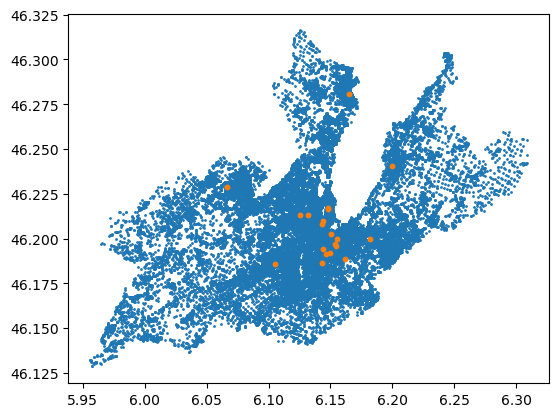

In [55]:
ax = gdf_nodes.plot(markersize = 1)
gdf_centre.plot(markersize = 10, ax = ax)

In [56]:
# Get nearest 2 POIs (screening center) at max 5km
net=pdna.Network(gdf_nodes["x"], gdf_nodes["y"], gdf_edges["u"], gdf_edges["v"],
                 gdf_edges[["length"]])
net.precompute(5000)
net.set_pois(category='centre', maxdist = 5000, maxitems=len(gdf_centre), x_col=gdf_centre['lon'], y_col=gdf_centre['lat'])
nearest_2 = net.nearest_pois(5000, "centre", num_pois=2)

Generating contraction hierarchies with 10 threads.
Setting CH node vector of size 61208
Setting CH edge vector of size 161129
Range graph removed 149890 edges of 322258
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [57]:
# Get POI density (screening centers) within 5km

x, y = gdf_centre.lon, gdf_centre.lat

gdf_centre["node_ids"] = net.get_node_ids(x, y)
net.set(gdf_centre["node_ids"], variable=gdf_centre['quantity'], name="centre")
density5000 = net.aggregate(5000, type="sum", decay="linear", name="centre")

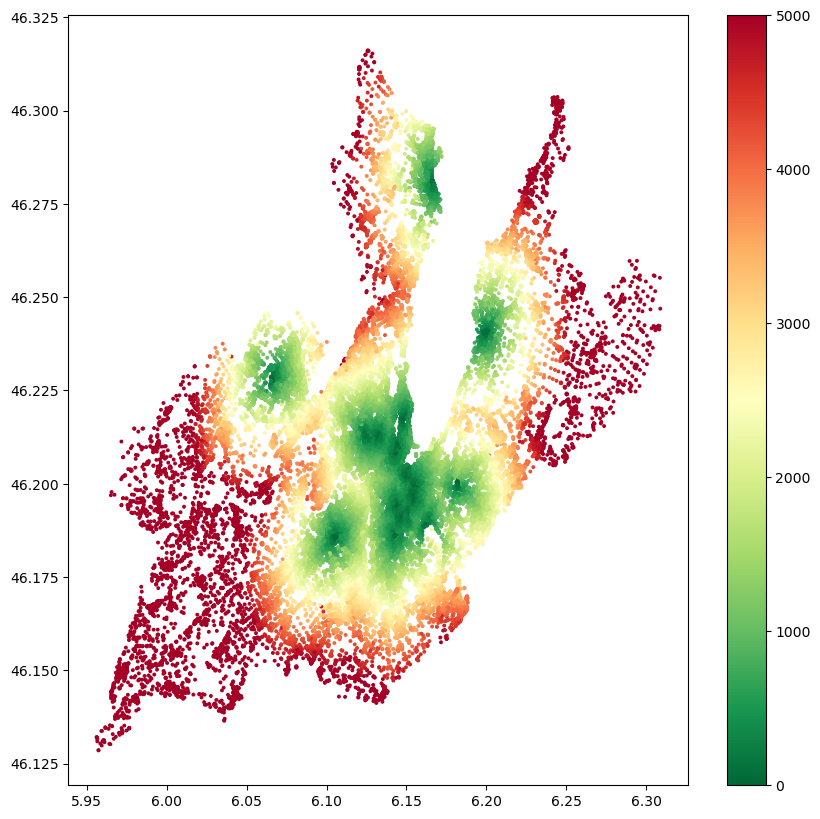

(<Figure size 1000x1000 with 2 Axes>, <Axes: >)

In [59]:
net.plot(nearest_2[1],
         fig_kwargs={'figsize': [10, 10]},
         plot_kwargs={'cmap': 'RdYlGn_r', 's': 8, 'edgecolor': 'none'})

In [60]:
nn_xy = ox.distance.nearest_nodes(Gp_2056, gdf_geocoded_ok.geometry.x, gdf_geocoded_ok.geometry.y)

In [61]:
gdf_geocoded_ok['nearest_node'] = nn_xy
gdf_geocoded_ok['center_nearest'] = gdf_geocoded_ok['nearest_node'].map(nearest_2[1].to_dict())

/Users/david/miniforge3/envs/giracs/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/david/miniforge3/envs/giracs/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [62]:
gdf_geocoded_ok['center_density'] = gdf_geocoded_ok['nearest_node'].map(density5000.to_dict())

/Users/david/miniforge3/envs/giracs/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [71]:
gdf_geocoded_ok_waccess = gdf_geocoded_ok.copy()

In [72]:
gdf_geocoded_ok_waccess = gpd.sjoin(gdf_geocoded_ok_waccess, cantons[cantons.NAME == 'Genève'][['geometry']], predicate = 'intersects')
gdf_geocoded_ok_waccess = gdf_geocoded_ok_waccess.drop('index_right', axis = 1)

In [73]:
print('Number of invitations :', gdf_geocoded_ok_waccess.shape[0])
print('Number of women :', gdf_geocoded_ok_waccess.numerodossier.nunique())

Number of invitations : 579033
Number of women : 134814


In [74]:
579184-579033

151

<Axes: >

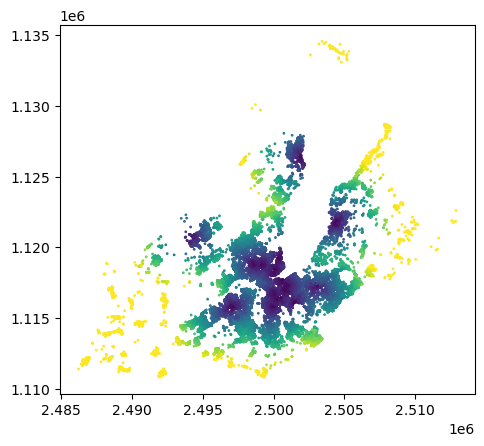

In [75]:
gdf_geocoded_ok_waccess[gdf_geocoded_ok_waccess.year_invit == 2019].plot('center_nearest', markersize = 1)

## SES Deprivation index

In [76]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Deprivation index

query = """select nbid,"LOCALITY" locality,ciqmd,ptot,pm,pf,p0004,p0509,p1014,p1519,p2024,p2529,p3034,p3539,p4044,p4549,p5054,p5559,p6064,p6569,p7074,p7579,p8084,p8589,p90m,rpmssin,rpmsmar,rpmswid,rpmsdiv,rad3prim, rad3sec,rad3tert,rprprot,rprcath,rprochr,rprjew,rprmusl,rproth,rprnorel,rpnch,
rpnoce,
rpncam,
rpncas,
rpnceu,rpneeu,rpneceu,rpnfe,rpnme,rpnnaf,rpnnam,rpnneu,rpnnweu,rpnsam,rpnsas,rpnseas,rpnseeu,rpnsweu,rpnsubaf,rpnweu
,rphhpriv,rhhcoll,rhhp1p,rhhp2p,rhhp3p,rhhp4p,rhhp5p,rhhp6mp,rpfnone,rpfobl,rpfgen,rpfprof,rpfmat,rpfprsf,rpfprss ,rpfbac,rpfmas,rpfphd,rad,radf,radune,rado,radunef,radslib,dmdrent,b.geom geometry from data_raw.microgis_data_gva a, data_raw.microgis_geo_gva b where a.nbid = b."NBID" and b.geom is not null ;"""
microgis_data = gpd.GeoDataFrame.from_postgis(query,con = engine,geom_col = 'geometry')
# microgis_data = microgis_data.dropna()
microgis_data.crs = 'epsg:2056'



microgis_data['tertiary_education'] = microgis_data[['rpfbac','rpfmas','rpfphd']].sum(axis = 1)
microgis_data['rpforeign'] = 100 - microgis_data['rpnch']
microgis_data['wo_tertiary_education'] = 100-microgis_data['tertiary_education']
microgis_data['inv_ciqmd'] = -microgis_data['ciqmd']
microgis_data['inv_dmdrent'] = -microgis_data['dmdrent']
microgis_data['rad3primsec'] = 100 - microgis_data['rad3tert']
microgis_data['rp65+'] = (microgis_data.p6569+microgis_data.p7074+microgis_data.p7579+microgis_data.p8084+microgis_data.p8589+microgis_data.p90m)/microgis_data.ptot
microgis_data['rpdens'] = (microgis_data.ptot / microgis_data.geometry.area)*1000000
microgis_data['rphh3p-'] = microgis_data[['rhhp1p','rhhp2p','rhhp3p']].sum(axis = 1)
microgis_data['rphh3p+'] = 100 - microgis_data[['rhhp1p','rhhp2p','rhhp3p']].sum(axis = 1)
#Filter out any neighborhood having ptot = 0
microgis_data = microgis_data[microgis_data.ptot>0]

#Standardize selected variables
x = microgis_data[['rpforeign','inv_ciqmd','radune','wo_tertiary_education','inv_dmdrent','rad3primsec']].values
x = StandardScaler().fit_transform(x)

microgis_data.to_feather('./microgis_data_depriv.feather',index = False)

#PCA with 3 components
pca_depriv = PCA(n_components=3)
principalComponents_depriv = pca_depriv.fit_transform(x)

principal_depriv_Df = pd.DataFrame(data = principalComponents_depriv
             , columns = ['principal component 1', 'principal component 2','principal component 3'])

print('Explained variation per principal component: {}'.format(pca_depriv.explained_variance_ratio_))


microgis_data['deprivation_pca'] = -principalComponents_depriv.T[0]

# Fit your data on the scaler object
scaler = preprocessing.StandardScaler()
microgis_data[['deprivation_pca']] = scaler.fit_transform(microgis_data[['deprivation_pca']])
microgis_data['deprivation_pca'] = -principalComponents_depriv.T[0]
microgis_data['deprivation_pca_q5'] = pd.qcut(microgis_data['deprivation_pca'],5, labels = False)

pd.DataFrame(pca_depriv.components_,columns=microgis_data[['rpforeign','inv_ciqmd','radune','wo_tertiary_education','inv_dmdrent','rad3primsec']].columns,index = ['PC-1','PC-2','PC-3'])

Explained variation per principal component: [0.30674127 0.22933389 0.15024821]


,rpforeign,inv_ciqmd,radune,wo_tertiary_education,inv_dmdrent,rad3primsec
PC-1,-0.305498,-0.508366,-0.496704,-0.294852,-0.558469,0.051903
PC-2,-0.429990,0.092496,-0.184808,0.641354,0.032539,0.600005
PC-3,0.716065,-0.112465,-0.028790,-0.125366,-0.135918,0.663010


In [77]:
#Make spatial join to assign area-based variables to the GIRACS individuals
gdf_geom_ok_waccess = gpd.sjoin(gdf_geocoded_ok_waccess, microgis_data[['nbid','geometry']], how = 'left', predicate = 'intersects').drop('index_right',axis = 1)

In [70]:
# import math
# def minDistCalc(points,polygons):
#     """Checks the closest MicroGIS neighborhood for all the points that don't interesect. 
#     Iterates over the points, polygons and multipolygons and return the minDist"""
#     for i,line in points.iterrows():
#         if math.isnan(line.nbid) == True:
#             mindistance = 9999
#             for index,row in polygons.iterrows():
#                 if row.geometry.geom_type == 'Polygon':
#                     dist = row.geometry.exterior.distance(line.geometry)
#                     if dist<mindistance:
#                         mindistance,nbid,locality = dist, row.nbid,row.locality
#                 else:
#                     for poly in row['geometry'].geoms:
#                         dist = poly.exterior.distance(line.geometry)
#                         if dist<mindistance:
#                             mindistance,nbid,locality = dist, row.nbid,row.locality
#             print(nbid,locality)
#             points.at[i,'nbid'] = nbid #Note: .at returns an error (BlockManager blabla) when there are column name duplicates
# minDistCalc(gdf_geom_ok_waccess, microgis_data)

5232 Carouge GE
5232 Carouge GE
5232 Carouge GE
4603 Petit-Lancy
4603 Petit-Lancy
4603 Petit-Lancy
4952 Vésenaz
4080 Genève
4080 Genève
4080 Genève
3988 Genève
3988 Genève
3964 Genève
3964 Genève
3964 Genève
5301 Plan-les-Ouates
5301 Plan-les-Ouates
5301 Plan-les-Ouates
5301 Plan-les-Ouates
4966 Vésenaz
4966 Vésenaz
3917 Genève
3890 Genève
103111 Confignon
98297 Versoix
98297 Versoix
98297 Versoix
98297 Versoix
102976 Genève
102976 Genève
102976 Genève
102976 Genève
102976 Genève
112793 Satigny
112793 Satigny
112793 Satigny
112793 Satigny
4970 Vésenaz
4970 Vésenaz
4781 Meyrin
4083 Genève
4083 Genève
4083 Genève
4083 Genève
4083 Genève
4777 Meyrin
6425 Bellevue
6425 Bellevue
5485 Puplinge
5485 Puplinge
5485 Puplinge
5485 Puplinge
5485 Puplinge
5485 Puplinge
4966 Vésenaz
4966 Vésenaz
4966 Vésenaz
4966 Vésenaz
4966 Vésenaz
4966 Vésenaz
4781 Meyrin
4952 Vésenaz
4952 Vésenaz
4952 Vésenaz
4952 Vésenaz
4952 Vésenaz
3924 Genève
6267 Dardagny
4809 Meyrin
4781 Meyrin
4781 Meyrin
4484 Genève
4484

KeyboardInterrupt: 

In [78]:
import geopandas as gpd
import numpy as np

def min_dist_calc(points, polygons):
    """
    Calculates the minimum distance from each point to the closest polygon when they don't intersect.
    Updates the 'nbid' in the points GeoDataFrame with the id of the closest polygon.
    """
    # Ensure 'nbid' is a float for nan checks
    points['nbid'] = points['nbid'].astype(float)

    # Iterate only over points without an 'nbid'
    for i, point in points.loc[points['nbid'].isna()].iterrows():
        min_distance = np.inf
        closest_nbid = None
        closest_locality = None
        
        # Check distance for each polygon
        for index, polygon in polygons.iterrows():
            geom = polygon.geometry
            if geom.geom_type == 'Polygon':
                dist = geom.exterior.distance(point.geometry)
            else:  # MultiPolygon case
                dist = min(poly.exterior.distance(point.geometry) for poly in geom.geoms)
            
            if dist < min_distance:
                min_distance, closest_nbid, closest_locality = dist, polygon.nbid, polygon.locality
        
        # Update points GeoDataFrame with the closest 'nbid' and print/log results
        points.at[i, 'nbid'] = closest_nbid
        # Consider replacing print with logging for production code
        print(closest_nbid, closest_locality)

# Example usage (assuming gdf_geom_ok_waccess and microgis_data are defined appropriately)
minDistCalc(gdf_geom_ok_waccess, microgis_data)

5232 Carouge GE
5232 Carouge GE
5232 Carouge GE
4603 Petit-Lancy
4603 Petit-Lancy
4603 Petit-Lancy
4952 Vésenaz
4080 Genève
4080 Genève
4080 Genève
3988 Genève
3988 Genève
3964 Genève
3964 Genève
3964 Genève
5301 Plan-les-Ouates
5301 Plan-les-Ouates
5301 Plan-les-Ouates
5301 Plan-les-Ouates
4966 Vésenaz
4966 Vésenaz
3917 Genève
3890 Genève
103111 Confignon
98297 Versoix
98297 Versoix
98297 Versoix
98297 Versoix
102976 Genève
102976 Genève
102976 Genève
102976 Genève
102976 Genève
112793 Satigny
112793 Satigny
112793 Satigny
112793 Satigny
4970 Vésenaz
4970 Vésenaz
4781 Meyrin
4083 Genève
4083 Genève
4083 Genève
4083 Genève
4083 Genève
4777 Meyrin
6425 Bellevue
6425 Bellevue
5485 Puplinge
5485 Puplinge
5485 Puplinge
5485 Puplinge
5485 Puplinge
5485 Puplinge
4966 Vésenaz
4966 Vésenaz
4966 Vésenaz
4966 Vésenaz
4966 Vésenaz
4966 Vésenaz
4781 Meyrin
4952 Vésenaz
4952 Vésenaz
4952 Vésenaz
4952 Vésenaz
4952 Vésenaz
3924 Genève
6267 Dardagny
4809 Meyrin
4781 Meyrin
4781 Meyrin
4484 Genève
4484

In [79]:
columns_to_merge = [
    'nbid', 'deprivation_pca', 'rpdens', 'deprivation_pca_q5','ptot','ciqmd', 'pf',
    'p0004', 'p0509', 'p1014', 'p1519', 'p2024', 'p2529', 'p3034', 'p3539', 
    'p4044', 'p4549', 'p5054', 'p5559', 'p6064', 'p6569', 'p7074', 'p7579', 
    'p8084', 'p8589', 'p90m', 'rpnoce', 'rpncam', 'rpncas', 'rpnceu', 
    'rpneeu', 'rpneceu', 'rpnfe', 'rpnme', 'rpnnaf', 'rpnnam', 'rpnneu', 
    'rpnnweu', 'rpnsam', 'rpnsas', 'rpnseas', 'rpnseeu', 'rpnsweu', 
    'rpnsubaf', 'rpnweu', 'tertiary_education', 'rpforeign', 
    'wo_tertiary_education', 'inv_ciqmd', 'inv_dmdrent','dmdrent', 'rad3primsec', 
    'rp65+', 'rphh3p-', 'rphh3p+','rad3sec', 'rad3tert', 'rprprot', 'rprcath', 'rprochr', 'rprjew', 'rprmusl', 'rproth', 'rprnorel', 'rpnch', 'rphhpriv', 'rpfnone', 'rpfobl', 'rpfgen', 'rpfprof', 'rpfmat', 'rpfprsf', 'rpfprss', 'rpfbac', 'rpfmas', 'rpfphd', 'rad', 'radf', 'radune', 'radslib'

]

gdf_geocoded_ok_waccess_wmicrogis = pd.merge(
    gdf_geom_ok_waccess, 
    microgis_data[columns_to_merge], 
    on='nbid',
    how='left'
)

In [112]:
import contextily as ctx
from matplotlib_scalebar.scalebar import ScaleBar
dict_cl = {np.nan:'#bababa',0:'#0571b0',
1:'#92c5de',
2:'#f7f7f7',
3:'#f4a582',
4:'#ca0020'}
hmap = colors.ListedColormap([dict_cl[i] for i in microgis_data['deprivation_pca_q5'].sort_values().unique()])


dict_cl = {np.nan:'#bababa',4:'#d7191c',
3:'#fdae61',
2:'#ffffbf',
1:'#abd9e9',
0:'#2c7bb6'}
microgis_data['depriv_color'] = microgis_data['deprivation_pca_q5'].map(dict_cl)

In [113]:
microgis_data['depriv_color'].isna().sum()

0

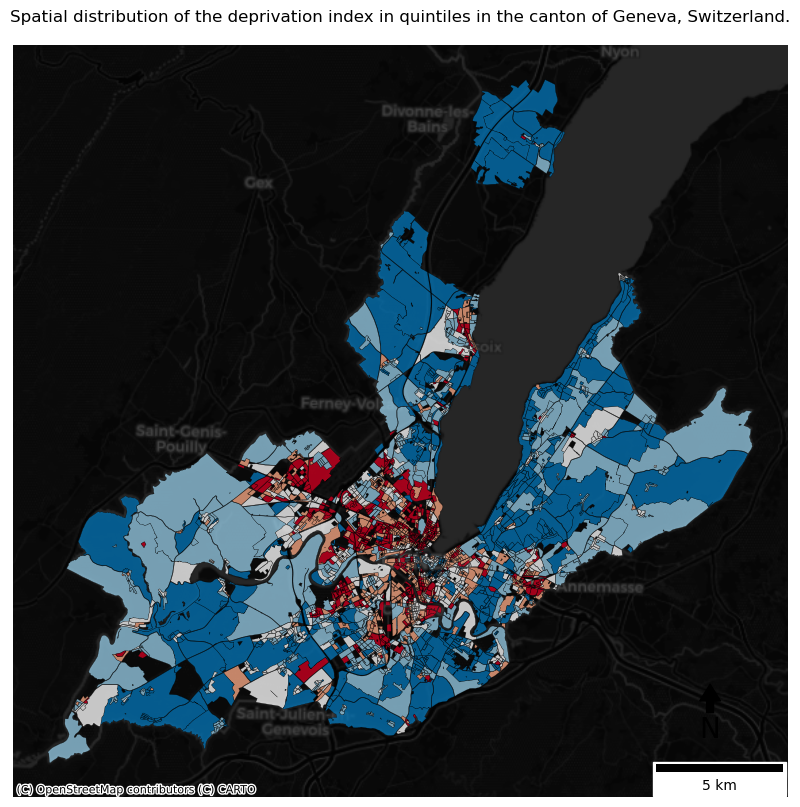

In [114]:
ax = microgis_data.plot('deprivation_pca_q5',alpha = 0.8,figsize = (10,10),cmap=hmap , linewidth = 0.2, edgecolor = 'k')
ax.set_title('Spatial distribution of the deprivation index in quintiles in the canton of Geneva, Switzerland.')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatter,crs = 'EPSG:2056')
# add scale bar
scalebar = ScaleBar(1, units="m", location="lower right")
ax.add_artist(scalebar)
ax.set_axis_off()
x, y, arrow_length = 0.9, 0.15, 0.06
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)
plt.savefig(result_folder/'Deprivation_cantongva.png',dpi = 800, bbox_inches='tight')

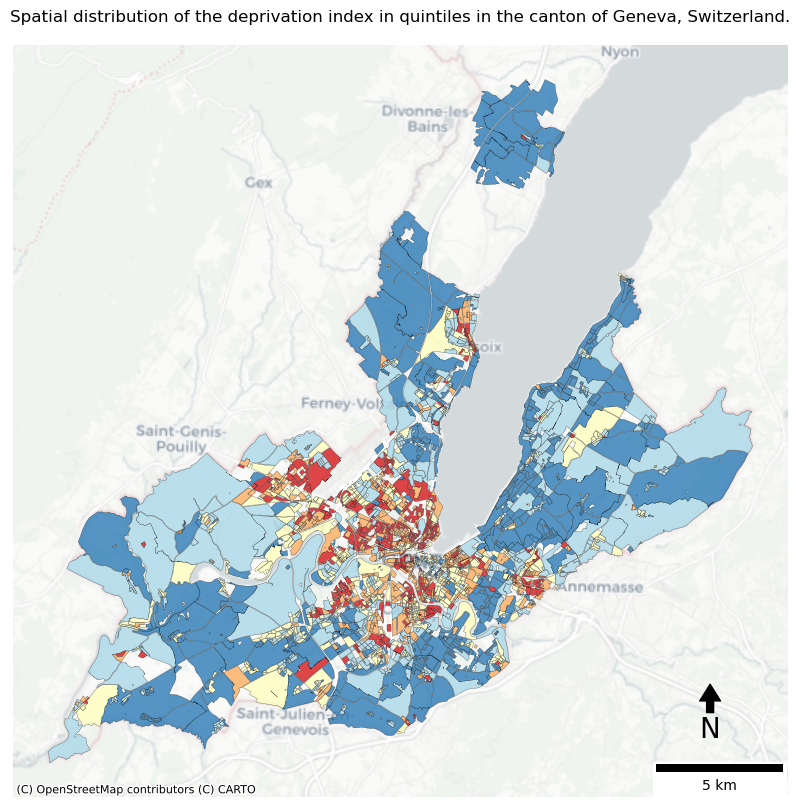

In [116]:
ax = microgis_data.plot(alpha = 0.8,figsize = (10,10),color = microgis_data.depriv_color , linewidth = 0.2, edgecolor = 'k')
ax.set_title('Spatial distribution of the deprivation index in quintiles in the canton of Geneva, Switzerland.')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron,crs = 'EPSG:2056')
# add scale bar
scalebar = ScaleBar(1, units="m", location="lower right")
ax.add_artist(scalebar)
ax.set_axis_off()
x, y, arrow_length = 0.9, 0.15, 0.06
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)
plt.savefig(result_folder/'Deprivation_cantongva.png',dpi = 800)

In [117]:
microgis_gva = microgis_data[microgis_data.locality == 'Genève']

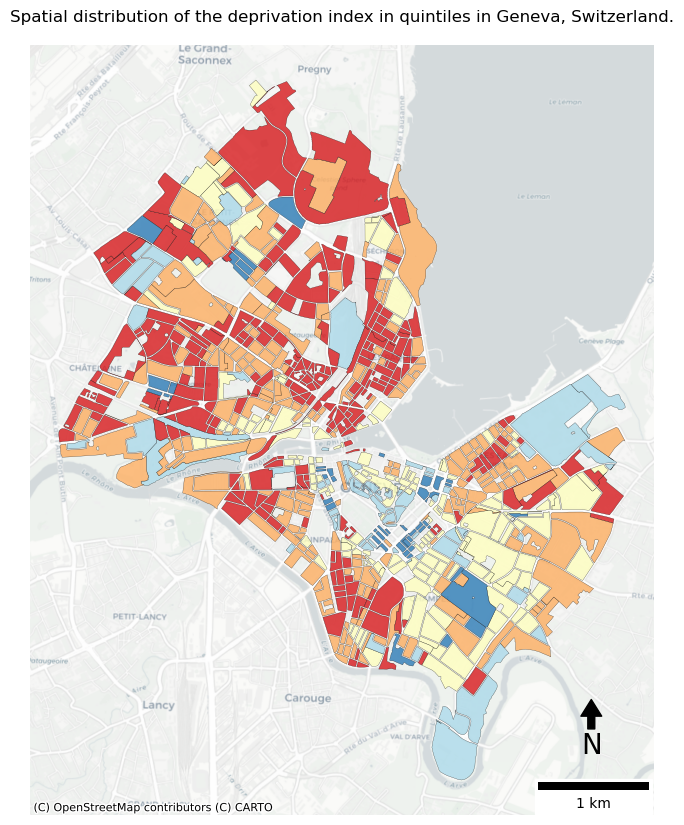

In [118]:
ax = microgis_gva.plot(alpha = 0.8,figsize = (10,10),color = microgis_gva.depriv_color, linewidth = 0.2, edgecolor = 'k')
ax.set_title('Spatial distribution of the deprivation index in quintiles in Geneva, Switzerland.')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron,crs = 'EPSG:2056')
# add scale bar
scalebar = ScaleBar(1, units="m", location="lower right")
ax.add_artist(scalebar)
ax.set_axis_off()
x, y, arrow_length = 0.9, 0.15, 0.06
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)
plt.savefig(result_folder/'Deprivation_gva.png',dpi = 800)

In [119]:
microgisSESindexR = pd.read_feather('../Data/Processed data/microgis_GE_indexSES.feather')

In [120]:
microgis_data = pd.merge(microgis_data,microgisSESindexR[['nbid','index_socio_class']], on = 'nbid')
microgis_data['index_socio_class'] = microgis_data['index_socio_class'].astype(int)
microgis_data['depriv_color_pkg_Lalloue'] = microgis_data['index_socio_class'].map(dict_cl)

In [122]:
microgis_data.index_socio_class.value_counts()

index_socio_class
3    842
4    594
2    393
5    328
1     33
Name: count, dtype: int64

In [123]:
# ax = microgis_data.plot(alpha = 0.8,figsize = (10,10),color = microgis_data.depriv_color_pkg_Lalloue , linewidth = 0.2, edgecolor = 'k')
# ax.set_title('Spatial distribution of the deprivation index in quintiles in the canton of Geneva, Switzerland.')
# ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron,crs = 'EPSG:2056')
# # add scale bar
# scalebar = ScaleBar(1, units="m", location="lower right")
# ax.add_artist(scalebar)
# ax.set_axis_off()
# x, y, arrow_length = 0.9, 0.15, 0.06
# ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
#             arrowprops=dict(facecolor='black', width=5, headwidth=15),
#             ha='center', va='center', fontsize=20,
#             xycoords=ax.transAxes)
# plt.savefig(result_folder/'Deprivation_cantongva.png',dpi = 800)

## Add median income at the sous-secteur scale

In [124]:
ss_income = pd.read_excel('../../GeoSalt/Data/OCTSTAT_historique_revenus_2005_2016.xlsx',sheet_name = "Sheet1")

In [129]:
query = """select * from geounits.geo_girec;"""
geo_girec = gpd.GeoDataFrame.from_postgis(query,con = engine,geom_col = 'geom')

In [130]:
geo_girec['NUMERO'] = geo_girec['NUMERO'].astype(int)

ss_income = pd.merge(ss_income,geo_girec[['NUMERO','geom']],left_on = 'code_ss',right_on = 'NUMERO',how = 'left').drop('NUMERO',axis = 1)

ss_income = gpd.GeoDataFrame(ss_income,geometry = ss_income['geom'])
ss_income.crs = 'epsg:2056'

df_final = gpd.sjoin(gdf_geom_ok_waccess,ss_income, how = 'left',predicate = 'intersects').drop('index_right',axis = 1)

In [131]:
df_final.loc[df_final.year_invit < 2006,'income_ss'] = df_final[2005]
df_final.loc[df_final.year_invit == 2006,'income_ss'] = df_final[2006]
df_final.loc[df_final.year_invit == 2007,'income_ss'] = df_final[2007]
df_final.loc[df_final.year_invit == 2008,'income_ss'] = df_final[2008]
df_final.loc[df_final.year_invit == 2009,'income_ss'] = df_final[2009]
df_final.loc[df_final.year_invit == 2010,'income_ss'] = df_final[2010]
df_final.loc[df_final.year_invit == 2011,'income_ss'] = df_final[2011]
df_final.loc[df_final.year_invit == 2012,'income_ss'] = df_final[2012]
df_final.loc[df_final.year_invit == 2013,'income_ss'] = df_final[2013]
df_final.loc[df_final.year_invit == 2014,'income_ss'] = df_final[2014]
df_final.loc[df_final.year_invit == 2015,'income_ss'] = df_final[2015]
df_final.loc[df_final.year_invit >= 2016,'income_ss'] = df_final[2016]

In [132]:
# df_final = df_final[~df_final.income_ss.isnull()]
participants_after = df_final.shape[0]
print(f'After removing respondents who were missing income there were left {participants_after} participants.')
print('Number of people in the dataset: ',len(df_final.numerodossier.unique()))

After removing respondents who were missing income there were left 579033 participants.
Number of people in the dataset:  134814


## Final checks

In [133]:
df_giracs = gdf_geocoded_ok_waccess_wmicrogis.copy()

In [134]:
df_giracs['longitude'] = df_giracs.to_crs(epsg=4326).geometry.x
df_giracs['latitude'] = df_giracs.to_crs(epsg=4326).geometry.y

In [135]:
df_giracs['age_cat'] = pd.factorize(df_giracs['groupeage'], sort=True)[0] + 1 

In [136]:
df_giracs = pd.concat([df_giracs,pd.get_dummies(df_giracs.groupeage)],axis = 1)

In [137]:
## Do we have any remaining NaNs?
df_giracs.isna().sum().sort_values().tail(40)

ptot                           0
numeroinvitation_seq_n         0
numeroinvitation_seq           0
dt_invit                       0
p1519                          0
ciqmd                          0
p2024                          0
p2529                          0
p3034                          0
p0509                          0
nbid                           0
zipcode                        1
adr_num                      390
participation_change       28000
etatcivil                  34161
adresse1                   39842
profession                 84019
diff_years                134404
mammo_last_invite         134404
daterappel                189799
t_invit_rappel            189799
year_rappel               189799
weekday_rappel            189799
day_rappel                189799
month_rappel              189799
mammoanterieure           402044
mammoanterieure_code      402376
atf                       406264
atf_code                  410234
t_invit_mammo             417385
weekday_ma

In [138]:
print('Number of invitations :', gdf_geocoded_ok_waccess.shape[0])
print('Number of women :', gdf_geocoded_ok_waccess.numerodossier.nunique())

Number of invitations : 579033
Number of women : 134814


In [139]:
df_giracs.to_feather('../Data/Processed data/20230627_GIRACS_all.feather',index = False)